# Compound Activity

Aim: Find compounds which activate the target

## Install Modules

In [27]:
%%capture
try:
    from rdkit.Chem import PandasTools
    from chembl_webresource_client.new_client import new_client
except:
    !pip install chembl_webresource_client
    !pip install rdkit

import math
from pathlib import Path
from zipfile import ZipFile
from tempfile import TemporaryDirectory
from rdkit.Chem import PandasTools
from chembl_webresource_client.new_client import new_client
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

In [18]:
HERE = Path(_dh[-1])
DATA = HERE / "data"

## ChEMBL API Setup

In [19]:
targets_api = new_client.target
compounds_api = new_client.molecule
bioactivities_api = new_client.activity

## Retrieve Target Information

In [20]:
uniprot_id = "P18031" #PTP1B (2QBS)

In [21]:
# Get target information from ChEMBL but restrict it to specified values only
targets = targets_api.get(target_components__accession=uniprot_id).only(
    "target_chembl_id", "organism", "pref_name", "target_type"
)
print(f'The type of the targets is "{type(targets)}"')

The type of the targets is "<class 'chembl_webresource_client.query_set.QuerySet'>"


In [22]:
# Select first entry
targets = pd.DataFrame.from_records(targets)
targets

,organism,pref_name,target_chembl_id,target_type
0,Homo sapiens,Protein-tyrosine phosphatase 1B,CHEMBL335,SINGLE PROTEIN
1,Homo sapiens,Protein-tyrosine phosphatase 1B,CHEMBL335,SINGLE PROTEIN


In [23]:
target = targets.iloc[0]
target

organism                               Homo sapiens
pref_name           Protein-tyrosine phosphatase 1B
target_chembl_id                          CHEMBL335
target_type                          SINGLE PROTEIN
Name: 0, dtype: object

In [24]:
chembl_id = target.target_chembl_id
print(f"The target ChEMBL ID is {chembl_id}")
# NBVAL_CHECK_OUTPUT

The target ChEMBL ID is CHEMBL335


## Retrieve Bio-activity
assay data will be retrieved from the protein target

In [25]:
bioactivities = bioactivities_api.filter(
    target_chembl_id=chembl_id, type="IC50", relation="=", assay_type="B"
).only(
    "activity_id",
    "assay_chembl_id",
    "assay_description",
    "assay_type",
    "molecule_chembl_id",
    "type",
    "standard_units",
    "relation",
    "standard_value",
    "target_chembl_id",
    "target_organism",
)

print(f"Length and type of bioactivities object: {len(bioactivities)}, {type(bioactivities)}")

Length and type of bioactivities object: 3437, <class 'chembl_webresource_client.query_set.QuerySet'>


In [26]:
print(f"Length and type of first element: {len(bioactivities[0])}, {type(bioactivities[0])}")
bioactivities[0]

Length and type of first element: 13, <class 'dict'>


{'activity_id': 33473,
 'assay_chembl_id': 'CHEMBL772435',
 'assay_description': 'In vitro inhibitory activity against recombinant human protein-tyrosine phosphatase 1B (PTP1B) using fluorescein diphosphate (FDP) as a substrate',
 'assay_type': 'B',
 'molecule_chembl_id': 'CHEMBL301254',
 'relation': '=',
 'standard_units': 'nM',
 'standard_value': '1540.0',
 'target_chembl_id': 'CHEMBL335',
 'target_organism': 'Homo sapiens',
 'type': 'IC50',
 'units': 'uM',
 'value': '1.54'}

In [28]:
bioactivities_df.from_records = pd.DataFrame.from_records(bioactivities)
print(f"DataFrame shape: {bioactivities_df.shape}")
bioactivities_df.head()

DataFrame shape: (3437, 13)


,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type,units,value
0,33473,CHEMBL772435,In vitro inhibitory activity against recombina...,B,CHEMBL301254,=,nM,1540.0,CHEMBL335,Homo sapiens,IC50,uM,1.54
1,33479,CHEMBL772435,In vitro inhibitory activity against recombina...,B,CHEMBL58435,=,nM,10130.0,CHEMBL335,Homo sapiens,IC50,uM,10.13
2,34712,CHEMBL770122,Inhibition of human Protein-tyrosine phosphata...,B,CHEMBL57157,=,nM,610.0,CHEMBL335,Homo sapiens,IC50,uM,0.61
3,34713,CHEMBL770122,Inhibition of human Protein-tyrosine phosphata...,B,CHEMBL292444,=,nM,1010.0,CHEMBL335,Homo sapiens,IC50,uM,1.01
4,34733,CHEMBL772435,In vitro inhibitory activity against recombina...,B,CHEMBL60707,=,nM,1130.0,CHEMBL335,Homo sapiens,IC50,uM,1.13


In [29]:
bioactivities_df["units"].unique()

array(['uM', 'nM', 'mM', 'ug ml-1', 'microM', 'umol/L', 'umol/ml',
       "10'-5M", "10'20 uM"], dtype=object)

In [30]:
# Remove irrelevant data
bioactivities_df.drop(["units", "value"], axis=1, inplace=True)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,33473,CHEMBL772435,In vitro inhibitory activity against recombina...,B,CHEMBL301254,=,nM,1540.0,CHEMBL335,Homo sapiens,IC50
1,33479,CHEMBL772435,In vitro inhibitory activity against recombina...,B,CHEMBL58435,=,nM,10130.0,CHEMBL335,Homo sapiens,IC50
2,34712,CHEMBL770122,Inhibition of human Protein-tyrosine phosphata...,B,CHEMBL57157,=,nM,610.0,CHEMBL335,Homo sapiens,IC50
3,34713,CHEMBL770122,Inhibition of human Protein-tyrosine phosphata...,B,CHEMBL292444,=,nM,1010.0,CHEMBL335,Homo sapiens,IC50
4,34733,CHEMBL772435,In vitro inhibitory activity against recombina...,B,CHEMBL60707,=,nM,1130.0,CHEMBL335,Homo sapiens,IC50


In [31]:
bioactivities_df.dtypes

activity_id            int64
assay_chembl_id       object
assay_description     object
assay_type            object
molecule_chembl_id    object
relation              object
standard_units        object
standard_value        object
target_chembl_id      object
target_organism       object
type                  object
dtype: object

In [32]:
# Change the type of the IC50 values to float values
bioactivities_df = bioactivities_df.astype({"standard_value": "float64"})
bioactivities_df.dtypes

activity_id             int64
assay_chembl_id        object
assay_description      object
assay_type             object
molecule_chembl_id     object
relation               object
standard_units         object
standard_value        float64
target_chembl_id       object
target_organism        object
type                   object
dtype: object

In [33]:
bioactivities_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (3437, 11)


In [36]:
# Only keep entries which are measured in nM
print(f"Units in downloaded data: {bioactivities_df['standard_units'].unique()}")
print(
    f"Number of non-nM entries:\
    {bioactivities_df[bioactivities_df['standard_units'] != 'nM'].shape[0]}"
)
bioactivities_df = bioactivities_df[bioactivities_df["standard_units"] == "nM"]
print(f"Units after filtering: {bioactivities_df['standard_units'].unique()}")
print(f"DataFrame shape: {bioactivities_df.shape}")

Units in downloaded data: ['nM']
Number of non-nM entries:    0
Units after filtering: ['nM']
DataFrame shape: (3369, 11)


There are some double entries in the dataframe so duplicate entries will be averaged

In [70]:
mean = bioactivities_df.groupby('molecule_chembl_id').mean().reset_index()
unique = bioactivities_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=False)
unique.sort_values('molecule_chembl_id', inplace=True)
unique['standard_value'] = mean['standard_value'].values

bioactivities_df = unique
bioactivities_df.head()


,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
91,439847,CHEMBL771320,Inhibitory activity against human Protein-tyro...,B,CHEMBL100267,=,nM,20000000.0,CHEMBL335,Homo sapiens,IC50
504,1264005,CHEMBL772439,Inhibitory concentration towards recombinant h...,B,CHEMBL101427,=,nM,19000.0,CHEMBL335,Homo sapiens,IC50
491,1228545,CHEMBL772439,Inhibitory concentration towards recombinant h...,B,CHEMBL102015,=,nM,24000.0,CHEMBL335,Homo sapiens,IC50
492,1229794,CHEMBL772439,Inhibitory concentration towards recombinant h...,B,CHEMBL103709,=,nM,25000.0,CHEMBL335,Homo sapiens,IC50
493,1234702,CHEMBL772439,Inhibitory concentration towards recombinant h...,B,CHEMBL103942,=,nM,30000.0,CHEMBL335,Homo sapiens,IC50


In [56]:
mean

,molecule_chembl_id,activity_id,standard_value
0,CHEMBL100267,439847.0,20000000.0
1,CHEMBL101427,1264005.0,19000.0
2,CHEMBL102015,1228545.0,24000.0
3,CHEMBL103709,1229794.0,25000.0
4,CHEMBL103942,1234702.0,30000.0
...,...,...,...
2984,CHEMBL99271,596568.0,21000.0
2985,CHEMBL99657,595199.0,24000.0
2986,CHEMBL99776,592733.0,24000.0
2987,CHEMBL99971,467482.0,12000000.0


In [71]:
bioactivities_df.reset_index(drop=True, inplace=True)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,439847,CHEMBL771320,Inhibitory activity against human Protein-tyro...,B,CHEMBL100267,=,nM,20000000.0,CHEMBL335,Homo sapiens,IC50
1,1264005,CHEMBL772439,Inhibitory concentration towards recombinant h...,B,CHEMBL101427,=,nM,19000.0,CHEMBL335,Homo sapiens,IC50
2,1228545,CHEMBL772439,Inhibitory concentration towards recombinant h...,B,CHEMBL102015,=,nM,24000.0,CHEMBL335,Homo sapiens,IC50
3,1229794,CHEMBL772439,Inhibitory concentration towards recombinant h...,B,CHEMBL103709,=,nM,25000.0,CHEMBL335,Homo sapiens,IC50
4,1234702,CHEMBL772439,Inhibitory concentration towards recombinant h...,B,CHEMBL103942,=,nM,30000.0,CHEMBL335,Homo sapiens,IC50


In [72]:
bioactivities_df.rename(
    columns={"standard_value": "IC50", "standard_units": "units"}, inplace=True
)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,units,IC50,target_chembl_id,target_organism,type
0,439847,CHEMBL771320,Inhibitory activity against human Protein-tyro...,B,CHEMBL100267,=,nM,20000000.0,CHEMBL335,Homo sapiens,IC50
1,1264005,CHEMBL772439,Inhibitory concentration towards recombinant h...,B,CHEMBL101427,=,nM,19000.0,CHEMBL335,Homo sapiens,IC50
2,1228545,CHEMBL772439,Inhibitory concentration towards recombinant h...,B,CHEMBL102015,=,nM,24000.0,CHEMBL335,Homo sapiens,IC50
3,1229794,CHEMBL772439,Inhibitory concentration towards recombinant h...,B,CHEMBL103709,=,nM,25000.0,CHEMBL335,Homo sapiens,IC50
4,1234702,CHEMBL772439,Inhibitory concentration towards recombinant h...,B,CHEMBL103942,=,nM,30000.0,CHEMBL335,Homo sapiens,IC50


In [73]:
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (2989, 11)


## Get Compound Data
Molecular data of the compounds will be retrieved, namely the structure

In [74]:
compounds_provider = compounds_api.filter(
    molecule_chembl_id__in=list(bioactivities_df["molecule_chembl_id"])
).only("molecule_chembl_id", "molecule_structures")

In [75]:
compounds = list(tqdm(compounds_provider))

  0%|          | 0/2989 [00:00<?, ?it/s]

In [77]:
compounds_df = pd.DataFrame.from_records(
    compounds,
)
print(f"DataFrame shape: {compounds_df.shape}")
compounds_df.head()

DataFrame shape: (2989, 2)


,molecule_chembl_id,molecule_structures
0,CHEMBL408,{'canonical_smiles': 'Cc1c(C)c2c(c(C)c1O)CCC(C...
1,CHEMBL6518,{'canonical_smiles': 'CCCCCCCC/C(=C/Cn1oc(=O)n...
2,CHEMBL203751,{'canonical_smiles': 'Cc1oc(-c2ccc(C(F)(F)F)cc...
3,CHEMBL6845,{'canonical_smiles': 'C/C(=C\Cn1oc(=O)[nH]c1=O...
4,CHEMBL265665,{'canonical_smiles': 'CCCCCCCC/C(=C\Cn1oc(=O)n...


In [78]:
compounds_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (2983, 2)


In [79]:
compounds_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (2983, 2)


In [80]:
compounds_df.iloc[0].molecule_structures.keys()

dict_keys(['canonical_smiles', 'molfile', 'standard_inchi', 'standard_inchi_key'])

In [81]:
# Rows not having a canonical smiles structure will be removed
canonical_smiles = []

for i, compounds in compounds_df.iterrows():
    try:
        canonical_smiles.append(compounds["molecule_structures"]["canonical_smiles"])
    except KeyError:
        canonical_smiles.append(None)

compounds_df["smiles"] = canonical_smiles
compounds_df.drop("molecule_structures", axis=1, inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (2983, 2)


In [82]:
compounds_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (2983, 2)


In [85]:
print(f"Bioactivities filtered: {bioactivities_df.shape[0]}")

print(f"Compounds filtered: {compounds_df.shape[0]}")


Bioactivities filtered: 2989
Compounds filtered: 2983


In [86]:
# Merge DataFrames
output_df = pd.merge(
    bioactivities_df[["molecule_chembl_id", "IC50", "units"]],
    compounds_df,
    on="molecule_chembl_id",
)

# Reset row indices
output_df.reset_index(drop=True, inplace=True)

print(f"Dataset with {output_df.shape[0]} entries.")

Dataset with 2983 entries.


In [88]:
output_df.dtypes
output_df.head(10)

,molecule_chembl_id,IC50,units,smiles
0,CHEMBL100267,20000000.0,nM,COc1ccc2cc(C(=O)O)ccc2c1C(=O)O
1,CHEMBL101427,19000.0,nM,C[C@H]1CCC[C@@H](C)N1NC(=O)c1ccc(Cl)c(S(=O)(=O...
2,CHEMBL102015,24000.0,nM,O=C(NS(=O)(=O)Cc1ccccc1)c1ccc2cc(C(F)(F)P(=O)(...
3,CHEMBL103709,25000.0,nM,O=C(NS(=O)(=O)c1cc(C2(O)NC(=O)c3ccccc32)ccc1Cl...
4,CHEMBL103942,30000.0,nM,O=C(NS(=O)(=O)c1ccccc1)c1ccc2cc(C(F)(F)P(=O)(O...
5,CHEMBL105872,45000.0,nM,O=S(=O)(/C=C/c1ccc2ccccc2c1)Nc1nc(-c2ccccc2)c(...
6,CHEMBL105999,29000.0,nM,CCCc1sc(NS(=O)(=O)/C=C/c2ccc(F)c(F)c2)nc1-c1cc...
7,CHEMBL106194,58000.0,nM,N#Cc1ccc(/C=C/S(=O)(=O)Nc2nc(-c3ccccc3)c(-c3cc...
8,CHEMBL106479,85000.0,nM,O=S(=O)(/C=C/c1ccc(F)c(F)c1)Nc1nc(-c2ccccc2)c(...
9,CHEMBL1076247,65500.0,nM,CCOCC1(CN2CCN(C)CC2)COc2ccc3c(C)cc(=O)oc3c2C1=O


In [89]:
# For a less crowded distribution, the values will be converted to pIC50
def convert_ic50_to_pic50(IC50_value):
    pIC50_value = 9 - math.log10(IC50_value)
    return pIC50_value

In [91]:
# Apply conversion to each row of the compounds DataFrame
output_df["pIC50"] = output_df.apply(lambda x: convert_ic50_to_pic50(x.IC50), axis=1)
output_df.head()

,molecule_chembl_id,IC50,units,smiles,pIC50
0,CHEMBL100267,20000000.0,nM,COc1ccc2cc(C(=O)O)ccc2c1C(=O)O,1.698970
1,CHEMBL101427,19000.0,nM,C[C@H]1CCC[C@@H](C)N1NC(=O)c1ccc(Cl)c(S(=O)(=O...,4.721246
2,CHEMBL102015,24000.0,nM,O=C(NS(=O)(=O)Cc1ccccc1)c1ccc2cc(C(F)(F)P(=O)(...,4.619789
3,CHEMBL103709,25000.0,nM,O=C(NS(=O)(=O)c1cc(C2(O)NC(=O)c3ccccc32)ccc1Cl...,4.602060
4,CHEMBL103942,30000.0,nM,O=C(NS(=O)(=O)c1ccccc1)c1ccc2cc(C(F)(F)P(=O)(O...,4.522879


array([[<AxesSubplot:title={'center':'pIC50'}>]], dtype=object)

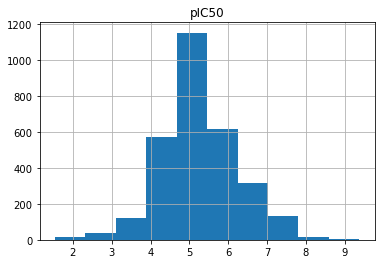

In [92]:
output_df.hist(column="pIC50")

In [93]:
# Add molecule column
PandasTools.AddMoleculeColumnToFrame(output_df, smilesCol="smiles")

In [94]:
# Sort molecules by pIC50
output_df.sort_values(by="pIC50", ascending=False, inplace=True)

# Reset index
output_df.reset_index(drop=True, inplace=True)

,molecule_chembl_id,IC50,units,smiles,pIC50,ROMol
0,CHEMBL4524071,0.42,nM,C/C=C1\C(=O)N[C@@H](C(=O)O)[C@H](C)C(=O)N[C@@H...,9.376751,
1,CHEMBL505512,0.67,nM,CO[C@H]([C@H](O)CC(=O)[C@@H](C)[C@@H](O)CC[C@@...,9.173925,
2,CHEMBL444092,1.17,nM,C=C1C(=O)N[C@H](C)C(=O)N[C@@H](CC(C)C)C(=O)N[C...,8.931814,
3,CHEMBL430266,1.20,nM,COC[C@@H]([C@H](O)[C@H](O)C(=O)NCC[C@H](C)c1nc...,8.920819,
4,CHEMBL280487,1.24,nM,C=C1[C@@H]([C@@H](O)C[C@H](C)[C@H]2O[C@@]3(CCC...,8.906578,
...,...,...,...,...,...,...
2978,CHEMBL324473,12200000.00,nM,C=CCOC(=O)/C=C\c1cccc(C(F)(F)P(=O)(O)O)c1.N.N,1.913640,
2979,CHEMBL169826,13000000.00,nM,CC(=O)N[C@@H](CC(=O)O)C(=O)N[C@@H](C)C(=O)N[C@...,1.886057,
2980,CHEMBL100267,20000000.00,nM,COc1ccc2cc(C(=O)O)ccc2c1C(=O)O,1.698970,
2981,CHEMBL95668,28000000.00,nM,O=S(=O)([O-])c1cccc2c(S(=O)(=O)[O-])cccc12.[Na...,1.552842,

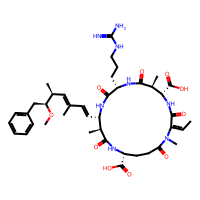
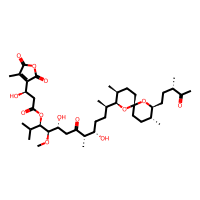
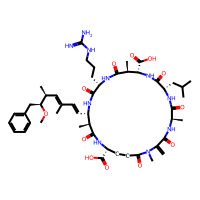
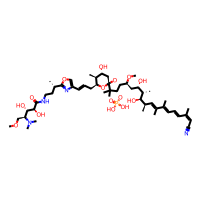
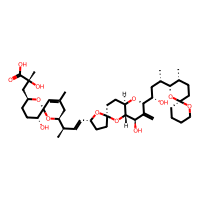
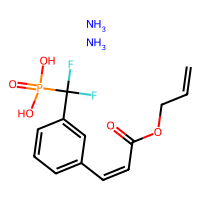
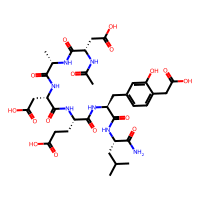
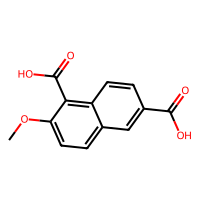
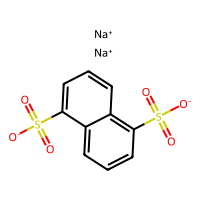
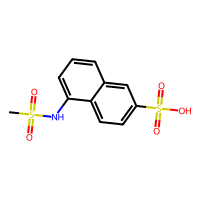

In [100]:
output_df.drop("smiles", axis=1)
output_df

In [101]:
# Prepare saving the dataset: Drop the ROMol column
output_df = output_df.drop("ROMol", axis=1)
print(f"DataFrame shape: {output_df.shape}")

DataFrame shape: (2983, 5)


In [103]:
# Save dataset for next notebook
output_df.to_csv(DATA / "PTP1B_compounds.csv")
output_df.head()

,molecule_chembl_id,IC50,units,smiles,pIC50
0,CHEMBL4524071,0.42,nM,C/C=C1\C(=O)N[C@@H](C(=O)O)[C@H](C)C(=O)N[C@@H...,9.376751
1,CHEMBL505512,0.67,nM,CO[C@H]([C@H](O)CC(=O)[C@@H](C)[C@@H](O)CC[C@@...,9.173925
2,CHEMBL444092,1.17,nM,C=C1C(=O)N[C@H](C)C(=O)N[C@@H](CC(C)C)C(=O)N[C...,8.931814
3,CHEMBL430266,1.20,nM,COC[C@@H]([C@H](O)[C@H](O)C(=O)NCC[C@H](C)c1nc...,8.920819
4,CHEMBL280487,1.24,nM,C=C1[C@@H]([C@@H](O)C[C@H](C)[C@H]2O[C@@]3(CCC...,8.906578
